In [1]:
# Convoluational NN is a subset of Deep learning (which is a broad term)
#   kernal - a part of a peice of data 3x3 pixels of a 5x5 picture -> looks for features
#   each layer adds complexity to features ex. egdes/corners -> squares/circles -> ect.
#   Convolutions are the chaning postion of kernal

! git clone https://github.com/kendreaditya/dogs_cats.git

Cloning into 'dogs_cats'...
remote: Enumerating objects: 24985, done.
remote: Total 24985 (delta 0), reused 0 (delta 0), pack-reused 24985
Receiving objects: 100% (24985/24985), 783.65 MiB | 30.31 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (25005/25005), done.


In [0]:
import os
import cv2
import numpy as np
from  tqdm import tqdm



In [3]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "dogs_cats/PetImages/Cat"
    DOGS = "dogs_cats/PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

  0%|          | 48/12501 [00:00<00:26, 477.02it/s]

dogs_cats/PetImages/Cat


  1%|          | 90/12501 [00:00<00:13, 890.68it/s]

dogs_cats/PetImages/Dog


100%|██████████| 12501/12501 [00:13<00:00, 917.28it/s]


Cats: 12476
Dogs: 12470


In [6]:
training_data = np.load("training_data.npy", allow_pickle=True)

print(len(training_data))
print(training_data[0]) 

24946
[array([[187, 188, 191, ..., 204, 203, 203],
       [187, 188, 189, ..., 204, 204, 203],
       [185, 188, 189, ..., 204, 202, 201],
       ...,
       [130, 135,  85, ..., 196, 195, 178],
       [130, 138, 138, ..., 170, 186, 182],
       [157, 167, 170, ..., 193, 177, 209]], dtype=uint8)
 array([1., 0.])]


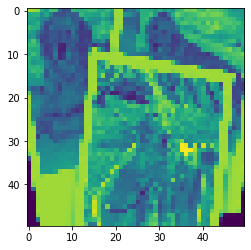

In [10]:
import matplotlib.pyplot as plt
plt.imshow(training_data[1][0])

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [25]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss().to(device)

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X /=225.0
y = torch.Tensor([i[1] for i in training_data])
 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [13]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

22452 2494


  4%|▍         | 9/225 [00:00<00:02, 80.59it/s]


Epoch: 0. Loss: 0.019465668126940727


  4%|▍         | 9/225 [00:00<00:02, 80.24it/s]


Epoch: 1. Loss: 0.01924153044819832


  4%|▎         | 8/225 [00:00<00:02, 79.34it/s]


Epoch: 2. Loss: 0.020061561837792397


  4%|▍         | 9/225 [00:00<00:02, 80.87it/s]


Epoch: 3. Loss: 0.047239430248737335


  4%|▍         | 9/225 [00:00<00:02, 80.31it/s]


Epoch: 4. Loss: 0.019152699038386345


  4%|▍         | 9/225 [00:00<00:02, 80.12it/s]


Epoch: 5. Loss: 0.01927938312292099


  4%|▍         | 9/225 [00:00<00:02, 80.35it/s]


Epoch: 6. Loss: 0.021033355966210365


  4%|▍         | 9/225 [00:00<00:02, 81.05it/s]


Epoch: 7. Loss: 0.019240645691752434


  4%|▍         | 9/225 [00:00<00:02, 81.16it/s]


Epoch: 8. Loss: 0.03640100732445717


  4%|▎         | 8/225 [00:00<00:02, 79.95it/s]


Epoch: 9. Loss: 0.032592035830020905


  4%|▍         | 9/225 [00:00<00:02, 79.99it/s]


Epoch: 10. Loss: 0.019937684759497643


  4%|▎         | 8/225 [00:00<00:02, 78.96it/s]


Epoch: 11. Loss: 0.019243460148572922


  4%|▍         | 9/225 [00:00<00:02, 81.05it/s]


Epoch: 12. Loss: 0.019243458285927773


  4%|▍         | 9/225 [00:00<00:02, 81.12it/s]


Epoch: 13. Loss: 0.027066048234701157


  4%|▍         | 9/225 [00:00<00:02, 81.16it/s]


Epoch: 14. Loss: 0.019279062747955322


  4%|▍         | 9/225 [00:00<00:02, 80.21it/s]


Epoch: 15. Loss: 0.01948186755180359


  4%|▎         | 8/225 [00:00<00:02, 79.35it/s]


Epoch: 16. Loss: 0.021778510883450508


  4%|▎         | 8/225 [00:00<00:02, 79.64it/s]


Epoch: 17. Loss: 0.03288590535521507


  4%|▍         | 9/225 [00:00<00:02, 81.16it/s]


Epoch: 18. Loss: 0.021152324974536896


  4%|▍         | 9/225 [00:00<00:02, 81.40it/s]


Epoch: 19. Loss: 0.02715921215713024


  4%|▍         | 9/225 [00:00<00:02, 80.83it/s]


Epoch: 20. Loss: 0.019231613725423813


  4%|▍         | 9/225 [00:00<00:02, 81.14it/s]


Epoch: 21. Loss: 0.019280608743429184


  4%|▎         | 8/225 [00:00<00:02, 79.85it/s]


Epoch: 22. Loss: 0.019273318350315094


  4%|▍         | 9/225 [00:00<00:02, 80.23it/s]


Epoch: 23. Loss: 0.026311108842492104


  4%|▍         | 9/225 [00:00<00:02, 81.79it/s]


Epoch: 24. Loss: 0.020537244156003


  4%|▍         | 9/225 [00:00<00:02, 81.31it/s]


Epoch: 25. Loss: 0.01944071799516678


  4%|▍         | 9/225 [00:00<00:02, 80.23it/s]


Epoch: 26. Loss: 0.021057438105344772


  4%|▍         | 9/225 [00:00<00:02, 79.82it/s]


Epoch: 27. Loss: 0.019234197214245796


  4%|▍         | 9/225 [00:00<00:02, 79.77it/s]


Epoch: 28. Loss: 0.027487020939588547


  4%|▍         | 9/225 [00:00<00:02, 81.23it/s]


Epoch: 29. Loss: 0.01922551356256008


  4%|▍         | 9/225 [00:00<00:02, 80.35it/s]


Epoch: 30. Loss: 0.019138306379318237


  4%|▍         | 9/225 [00:00<00:02, 80.80it/s]


Epoch: 31. Loss: 0.01782236434519291


  4%|▍         | 9/225 [00:00<00:02, 80.70it/s]


Epoch: 32. Loss: 0.03691764175891876


  4%|▍         | 9/225 [00:00<00:02, 80.04it/s]


Epoch: 33. Loss: 0.030996957793831825


  4%|▍         | 9/225 [00:00<00:02, 79.68it/s]


Epoch: 34. Loss: 0.019569704309105873


  4%|▎         | 8/225 [00:00<00:02, 78.86it/s]


Epoch: 35. Loss: 0.01944809965789318


  4%|▍         | 9/225 [00:00<00:02, 80.19it/s]


Epoch: 36. Loss: 0.020210299640893936


  4%|▍         | 9/225 [00:00<00:02, 79.66it/s]


Epoch: 37. Loss: 0.019230227917432785


  4%|▍         | 9/225 [00:00<00:02, 80.90it/s]


Epoch: 38. Loss: 0.01913653127849102


  4%|▎         | 8/225 [00:00<00:02, 79.45it/s]


Epoch: 39. Loss: 0.03172784298658371


  4%|▍         | 9/225 [00:00<00:02, 81.28it/s]


Epoch: 40. Loss: 0.023426759988069534


  4%|▍         | 9/225 [00:00<00:02, 80.43it/s]


Epoch: 41. Loss: 0.018908118829131126


  4%|▎         | 8/225 [00:00<00:02, 78.31it/s]


Epoch: 42. Loss: 0.019290583208203316


  4%|▍         | 9/225 [00:00<00:02, 81.31it/s]


Epoch: 43. Loss: 0.01924344152212143


  4%|▍         | 9/225 [00:00<00:02, 80.43it/s]


Epoch: 44. Loss: 0.01992333121597767


  4%|▍         | 9/225 [00:00<00:02, 81.36it/s]


Epoch: 45. Loss: 0.019255757331848145


  4%|▍         | 9/225 [00:00<00:02, 81.00it/s]


Epoch: 46. Loss: 0.019244495779275894


  4%|▍         | 9/225 [00:00<00:02, 81.17it/s]


Epoch: 47. Loss: 0.019273271784186363


  4%|▍         | 9/225 [00:00<00:02, 79.47it/s]


Epoch: 48. Loss: 0.018708940595388412


100%|██████████| 225/225 [00:02<00:00, 75.31it/s]


Epoch: 49. Loss: 0.019229460507631302
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [0.019465668126940727, 0.01924153044819832, 0.020061561837792397, 0.047239430248737335, 0.019152699038386345, 0.01927938312292099, 0.021033355966210365, 0.019240645691752434, 0.03640100732445717, 0.032592035830020905, 0.019937684759497643, 0.019243460148572922, 0.019243458285927773, 0.027066048234701157, 0.019279062747955322, 0.01948186755180359, 0.021778510883450508, 0.03288590535521507, 0.021152324974536896, 0.02715921215713024, 0.019231613725423813, 0.019280608743429184, 0.019273318350315094, 0.026311108842492104, 0.020537244156003, 0.01944071799516678, 0.021057438105344772, 0.019234197214245796, 0.027487020939588547, 0.01922551356256008, 0.019138306379318237, 0.01782236434519291, 0.03691764175891876, 0.030996957793831825, 0.019569704309105873, 0.01944809

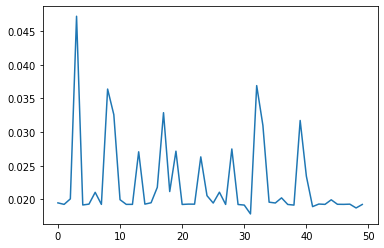

In [57]:
import matplotlib.pyplot as plt

BATCH_SIZE = 100
EPOCHS = 50
plot = []

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update
    
    plot.append([epoch, float(loss)])
    print(f"\nEpoch: {epoch}. Loss: {loss}")
plot = list(map(list, zip(*plot)))
print(plot)
plt.plot(plot[0], plot[1])

In [58]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i]).to(device)
        net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:02<00:00, 1226.74it/s]

Accuracy:  0.758


In [20]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on GPU -", device )
else:
  device = torch.device("cpu")
  print("Running on CPU -", device )

# to run on gpu .to(device)

Running on GPU - cuda:0


In [21]:
net.to(device)

1